# Unsupervised Learning Trading Strategy

* Download/Load SP500 stocks prices data.
* Calculate different features and indicators on each stock.
* Aggregate on monthly level and filter top 150 most liquid stocks.
* Calculate Monthly Returns for different time-horizons.
* Download Fama-French Factors and Calculate Rolling Factor Betas.
* For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.
* For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization.
* Visualize Portfolio returns and compare to SP500 returns.

# All Packages Needed:
* pandas, numpy, matplotlib, statsmodels, pandas_datareader, datetime, yfinance, sklearn, PyPortfolioOpt

## 1. Download/Load SP500 stocks prices data.

In [1]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [2]:
# import data

warnings.filterwarnings('ignore')

sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')

symbols_list = sp500['Symbol'].unique().tolist()

end_date = '2024-06-30'

start_date = pd.to_datetime(end_date)-pd.DateOffset(365*8)

df = yf.download(tickers=symbols_list,
                 start=start_date,
                 end=end_date).stack()

df.index.names = ['date', 'ticker']

df.columns = df.columns.str.lower()

df

[*********************100%%**********************]  503 of 503 completed

1 Failed download:
['SW']: YFChartError("%ticker%: Data doesn't exist for startDate = 1467432000, endDate = 1719720000")


Price               adj close       close        high         low        open  \
date       ticker                                                               
2016-07-05 A        41.086140   43.750000   44.349998   43.630001   44.310001   
           AAL      27.802406   28.930000   29.160000   28.190001   29.090000   
           AAPL     21.811760   23.747499   23.850000   23.615000   23.847500   
           ABBV     43.482296   61.919998   62.709999   61.770000   62.500000   
           ABT      33.861183   39.439999   39.560001   39.209999   39.310001   
...                       ...         ...         ...         ...         ...   
2024-06-28 XYL     135.630005  135.630005  137.990005  134.300003  136.639999   
           YUM     132.460007  132.460007  132.990005  131.720001  132.509995   
           ZBH     108.529999  108.529999  109.580002  107.379997  108.550003   
           ZBRA    308.929993  308.929993  314.040009  306.160004  309.000000   
           ZTS     172.948624  173.360001  177.070007  173.029999  176.460007   

Price                   volume  
date       ticker               
2016-07-05 A         1813500.0  
           AAL       9467000.0  
           AAPL    110820800.0  
           ABBV      6293600.0  
           ABT      10029300.0  
...                        ...  
2024-06-28 XYL       2197600.0  
           YUM       5819000.0  
           ZBH       2774600.0  
           ZBRA       417900.0  
           ZTS       4189600.0  

[989314 rows x 6 columns]

In [3]:
df1 = df
df2 = df.copy()
df3 = df

In [4]:
num, colu = df.loc[pd.IndexSlice['2024-06-06',:],:].shape
num
ticker=df.loc['2024-06-06',:].index
ticker

Index(['A', 'AAL', 'AAPL', 'ABBV', 'ABNB', 'ABT', 'ACGL', 'ACN', 'ADBE', 'ADI',
       ...
       'WTW', 'WY', 'WYNN', 'XEL', 'XOM', 'XYL', 'YUM', 'ZBH', 'ZBRA', 'ZTS'],
      dtype='object', name='ticker', length=502)

In [5]:
df_pred=df

In [14]:
features = ['Year', 'Month', 'Week', 'Day of the month', 'log_return', 'sma_50', 'sma_200', 'rsi']
targets = ['close', 'adj close', 'volume', 'high', 'low', 'open']

i = 0
for i in range(0,num):

    df_aapl = df1.loc[pd.IndexSlice[:, ticker[i]], :]
    df_aapl=df_aapl.reset_index()
    df_aapl['log_return'] = np.log(df_aapl['close'] / df_aapl['close'].shift(1))
    df_aapl['sma_50'] = df_aapl['close'].rolling(window=50).mean()
    df_aapl['sma_200'] = df_aapl['close'].rolling(window=200).mean()
    df_aapl['rsi'] = 100 - (100 / (1 + (df_aapl['close'].diff().rolling(window=14).mean() / df_aapl['close'].diff().rolling(window=14).std())))

    last_date = df_aapl['date'].max()
    new_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=150)
    new_data = {
    'date': new_dates,
    'ticker': ticker[i],
    'adj close': 0,
    'close': 0,
    'high': 0,
    'low': 0,
    'open': 0,
    'volume': 0,
    'log_return':0,
    'sma_200':0,
    'sma_50':0,
    'rsi':0
    }
    new_df = pd.DataFrame(new_data)
    df_aapl = pd.concat([df_aapl, new_df], ignore_index=True)

    df_aapl['Month'] = df_aapl['date'].dt.month
    df_aapl['Year'] = df_aapl['date'].dt.year
    df_aapl['Week'] = df_aapl['date'].dt.isocalendar().week
    df_aapl['Day of the month'] = df_aapl['date'].dt.day
    
    df_aapl.set_index('date', inplace=True)
    X = df_aapl[features]
    y = df_aapl[targets]
    
    train_size = len(df_aapl) - 150
    X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
    y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

    # Train the XGBoost model for each target
    models = {}
    for target in targets:
        model = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)
        model.fit(X_train, y_train[target])
        models[target] = model

    # Make predictions for each target
    predictions = {}
    for target in targets:
        predictions[target] = models[target].predict(X_test)

    # Combine predictions into a DataFrame
    predicted_df = pd.DataFrame(predictions, index=X_test.index)
    predicted_df['ticker']=ticker[i]
#     predicted_df = predicted_df.reset_index()
#     predicted_df.set_index('ticker', append=True, inplace=True)
    predicted_df.set_index(['ticker', predicted_df.index], inplace=True)
    predicted_df.index.names = ['ticker', 'date']
    predicted_df = predicted_df.reorder_levels(['date', 'ticker'])
  
    df = pd.concat([df2, predicted_df], ignore_index=False)


In [15]:
df_final = df
df_final1 = df

In [16]:
df = df.sort_index()
df

adj close      close       high        low       open  \
date       ticker                                                          
2016-07-05 A       41.086140  43.750000  44.349998  43.630001  44.310001   
           AAL     27.802406  28.930000  29.160000  28.190001  29.090000   
           AAPL    21.811760  23.747499  23.850000  23.615000  23.847500   
           ABBV    43.482296  61.919998  62.709999  61.770000  62.500000   
           ABT     33.861183  39.439999  39.560001  39.209999  39.310001   
...                      ...        ...        ...        ...        ...   
2024-11-21 ZTS     51.094147  53.862957  55.701801  54.420925  54.946949   
2024-11-22 ZTS     51.117981  53.978157  55.873470  54.420925  55.059685   
2024-11-23 ZTS     51.117981  54.042473  55.873470  54.420925  55.059685   
2024-11-24 ZTS     51.117981  54.090767  55.873287  54.527939  55.123386   
2024-11-25 ZTS     51.117981  54.090767  55.873287  55.323456  55.259567   

                         volume  
date       ticker                
2016-07-05 A       1.813500e+06  
           AAL     9.467000e+06  
           AAPL    1.108208e+08  
           ABBV    6.293600e+06  
           ABT     1.002930e+07  
...                         ...  
2024-11-21 ZTS     2.592042e+06  
2024-11-22 ZTS     2.390459e+06  
2024-11-23 ZTS     2.109866e+06  
2024-11-24 ZTS     2.109866e+06  
2024-11-25 ZTS     2.261112e+06  

[989464 rows x 6 columns]

In [19]:
# df_final = df_final.sortlevel()
df_final = df_final.groupby(level=[0,1]).sum()
df_final

adj close      close       high        low       open  \
date       ticker                                                          
2016-07-05 A       41.086140  43.750000  44.349998  43.630001  44.310001   
           AAL     27.802406  28.930000  29.160000  28.190001  29.090000   
           AAPL    21.811760  23.747499  23.850000  23.615000  23.847500   
           ABBV    43.482296  61.919998  62.709999  61.770000  62.500000   
           ABT     33.861183  39.439999  39.560001  39.209999  39.310001   
...                      ...        ...        ...        ...        ...   
2024-11-21 ZTS     51.094147  53.862957  55.701801  54.420925  54.946949   
2024-11-22 ZTS     51.117981  53.978157  55.873470  54.420925  55.059685   
2024-11-23 ZTS     51.117981  54.042473  55.873470  54.420925  55.059685   
2024-11-24 ZTS     51.117981  54.090767  55.873287  54.527939  55.123386   
2024-11-25 ZTS     51.117981  54.090767  55.873287  55.323456  55.259567   

                         volume  
date       ticker                
2016-07-05 A       1.813500e+06  
           AAL     9.467000e+06  
           AAPL    1.108208e+08  
           ABBV    6.293600e+06  
           ABT     1.002930e+07  
...                         ...  
2024-11-21 ZTS     2.592042e+06  
2024-11-22 ZTS     2.390459e+06  
2024-11-23 ZTS     2.109866e+06  
2024-11-24 ZTS     2.109866e+06  
2024-11-25 ZTS     2.261112e+06  

[989464 rows x 6 columns]

## 2. Calculate features and technical indicators for each stock.

* Garman-Klass Volatility
* RSI
* Bollinger Bands
* ATR
* MACD
* Dollar Volume

\begin{equation}
\text{Garman-Klass Volatility} = \frac{(\ln(\text{High}) - \ln(\text{Low}))^2}{2} - (2\ln(2) - 1)(\ln(\text{Adj Close}) - \ln(\text{Open}))^2
\end{equation}

In [20]:
df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)

df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])
                                                          
df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])
                                                          
df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
                        low=stock_data['low'],
                        close=stock_data['close'],
                        length=14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)

df['dollar_volume'] = (df['adj close']*df['volume'])/1e6

df

adj close      close       high        low       open  \
date       ticker                                                          
2016-07-05 A       41.086140  43.750000  44.349998  43.630001  44.310001   
           AAL     27.802406  28.930000  29.160000  28.190001  29.090000   
           AAPL    21.811760  23.747499  23.850000  23.615000  23.847500   
           ABBV    43.482296  61.919998  62.709999  61.770000  62.500000   
           ABT     33.861183  39.439999  39.560001  39.209999  39.310001   
...                      ...        ...        ...        ...        ...   
2024-11-21 ZTS     51.094147  53.862957  55.701801  54.420925  54.946949   
2024-11-22 ZTS     51.117981  53.978157  55.873470  54.420925  55.059685   
2024-11-23 ZTS     51.117981  54.042473  55.873470  54.420925  55.059685   
2024-11-24 ZTS     51.117981  54.090767  55.873287  54.527939  55.123386   
2024-11-25 ZTS     51.117981  54.090767  55.873287  55.323456  55.259567   

                         volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                        
2016-07-05 A       1.813500e+06         -0.002070        NaN       NaN   
           AAL     9.467000e+06         -0.000219        NaN       NaN   
           AAPL    1.108208e+08         -0.003027        NaN       NaN   
           ABBV    6.293600e+06         -0.050735        NaN       NaN   
           ABT     1.002930e+07         -0.008561        NaN       NaN   
...                         ...               ...        ...       ...   
2024-11-21 ZTS     2.592042e+06         -0.001771  44.624188  3.948360   
2024-11-22 ZTS     2.390459e+06         -0.001785  45.750265  3.948956   
2024-11-23 ZTS     2.109866e+06         -0.001785  45.750265  3.949663   
2024-11-24 ZTS     2.109866e+06         -0.001901  45.750265  3.949714   
2024-11-25 ZTS     2.261112e+06         -0.002296  45.750265  3.949768   

                     bb_mid   bb_high       atr      macd  dollar_volume  
date       ticker                                                         
2016-07-05 A            NaN       NaN       NaN       NaN      74.509714  
           AAL          NaN       NaN       NaN       NaN     263.205381  
           AAPL         NaN       NaN       NaN       NaN    2417.196687  
           ABBV         NaN       NaN       NaN       NaN     273.660178  
           ABT          NaN       NaN       NaN       NaN     339.603964  
...                     ...       ...       ...       ...            ...  
2024-11-21 ZTS     3.952378  3.956396 -0.936999 -0.011773     132.438162  
2024-11-22 ZTS     3.952620  3.956283 -0.905217 -0.010605     122.195425  
2024-11-23 ZTS     3.952862  3.956060 -0.880793 -0.009617     107.852116  
2024-11-24 ZTS     3.952917  3.956120 -0.860964 -0.008780     107.852116  
2024-11-25 ZTS     3.952972  3.956176 -0.844685 -0.008073     115.583480  

[989464 rows x 14 columns]

In [21]:
df_feature = df

## 3. Aggregate to monthly level and filter top 150 most liquid stocks for each month.

* To reduce training time and experiment with features and strategies, we convert the business-daily data to month-end frequency.

In [22]:
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open',
                                                          'high', 'low', 'close']]

data = (pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
                   df.unstack()[last_cols].resample('M').last().stack('ticker')],
                  axis=1)).dropna()

data

dollar_volume  adj close  garman_klass_vol        rsi  \
date       ticker                                                          
2016-08-31 A           87.662068  44.119469         -0.001640  50.780884   
           AAL        269.710248  34.989552         -0.000479  59.063133   
           AAPL      2718.975568  24.494835         -0.002162  57.326735   
           ABBV       306.400100  45.408325         -0.046259  42.552752   
           ABT        375.329267  36.298470         -0.010390  38.739695   
...                          ...        ...               ...        ...   
2024-07-31 ZTS        171.381048  51.490356         -0.001331  13.866985   
2024-08-31 ZTS        176.110907  51.488018         -0.001333  17.529066   
2024-09-30 ZTS        176.634852  51.557613         -0.001249  28.897651   
2024-10-31 ZTS        173.786570  51.284225         -0.001248  39.265334   
2024-11-30 ZTS        176.787103  51.117981         -0.002296  45.750265   

                     bb_low    bb_mid   bb_high       atr      macd  
date       ticker                                                    
2016-08-31 A       3.799092  3.820731  3.842369 -1.367656 -0.110174  
           AAL     3.511263  3.567882  3.624501  0.010620  0.859347  
           AAPL    3.235305  3.255475  3.275645 -1.321606 -0.117384  
           ABBV    3.835019  3.867038  3.899057 -1.510144 -0.274590  
           ABT     3.624830  3.667518  3.710207 -1.194762 -0.267446  
...                     ...       ...       ...       ...       ...  
2024-07-31 ZTS     3.957187  3.959279  3.961371 -0.669422 -2.378059  
2024-08-31 ZTS     3.955629  3.958497  3.961364 -1.291711 -0.223795  
2024-09-30 ZTS     3.957286  3.960159  3.963032 -1.380992 -0.014421  
2024-10-31 ZTS     3.953468  3.956927  3.960386 -1.446783 -0.013191  
2024-11-30 ZTS     3.949768  3.952972  3.956176 -0.844685 -0.008073  

[46759 rows x 9 columns]

In [23]:
data_copy = data

* Calculate 5-year rolling average of dollar volume for each stocks before filtering.

In [24]:
data['dollar_volume'] = (data.loc[:, 'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())

data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending=False))

data = data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

data

data_copy2 = data

## 4. Calculate Monthly Returns for different time horizons as features.

* To capture time series dynamics that reflect, for example, momentum patterns, we compute historical returns using the method .pct_change(lag), that is, returns over various monthly periods as identified by lags.

In [25]:
def calculate_returns(df):

    outlier_cutoff = 0.005

    lags = [1, 2, 3, 6, 9, 12]

    for lag in lags:

        df[f'return_{lag}m'] = (df['adj close']
                              .pct_change(lag)
                              .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                     upper=x.quantile(1-outlier_cutoff)))
                              .add(1)
                              .pow(1/lag)
                              .sub(1))
    return df
    
    
data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

data
data_final = data

## 5. Download Fama-French Factors and Calculate Rolling Factor Betas.

* We will introduce the Fama—French data to estimate the exposure of assets to common risk factors using linear regression.

* The five Fama—French factors, namely market risk, size, value, operating profitability, and investment have been shown empirically to explain asset returns and are commonly used to assess the risk/return profile of portfolios. Hence, it is natural to include past factor exposures as financial features in models.

* We can access the historical factor returns using the pandas-datareader and estimate historical exposures using the RollingOLS rolling linear regression.

In [26]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
                               'famafrench',
                               start='2010')[0].drop('RF', axis=1)

factor_data.index = factor_data.index.to_timestamp()

factor_data = factor_data.resample('M').last().div(100)

factor_data.index.name = 'date'

factor_data = factor_data.join(data['return_1m']).sort_index()

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2018-07-31 AAL     0.0319 -0.0193  0.0047  0.0156  0.0035   0.041623
           AAPL    0.0319 -0.0193  0.0047  0.0156  0.0035   0.027983
           ABBV    0.0319 -0.0193  0.0047  0.0156  0.0035   0.005634
           ABT     0.0319 -0.0193  0.0047  0.0156  0.0035   0.079433
           ACN     0.0319 -0.0193  0.0047  0.0156  0.0035  -0.026041
...                   ...     ...     ...     ...     ...        ...
2024-05-31 VRTX    0.0434  0.0059 -0.0133  0.0321 -0.0287   0.159186
           VZ      0.0434  0.0059 -0.0133  0.0321 -0.0287   0.042036
           WFC     0.0434  0.0059 -0.0133  0.0321 -0.0287   0.015922
           WMT     0.0434  0.0059 -0.0133  0.0321 -0.0287   0.111839
           XOM     0.0434  0.0059 -0.0133  0.0321 -0.0287  -0.000487

[10222 rows x 6 columns]

* Filter out stocks with less than 10 months of data.

In [27]:
observations = factor_data.groupby(level=1).size()

valid_stocks = observations[observations >= 10]

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2018-07-31 AAL     0.0319 -0.0193  0.0047  0.0156  0.0035   0.041623
           AAPL    0.0319 -0.0193  0.0047  0.0156  0.0035   0.027983
           ABBV    0.0319 -0.0193  0.0047  0.0156  0.0035   0.005634
           ABT     0.0319 -0.0193  0.0047  0.0156  0.0035   0.079433
           ACN     0.0319 -0.0193  0.0047  0.0156  0.0035  -0.026041
...                   ...     ...     ...     ...     ...        ...
2024-05-31 VRTX    0.0434  0.0059 -0.0133  0.0321 -0.0287   0.159186
           VZ      0.0434  0.0059 -0.0133  0.0321 -0.0287   0.042036
           WFC     0.0434  0.0059 -0.0133  0.0321 -0.0287   0.015922
           WMT     0.0434  0.0059 -0.0133  0.0321 -0.0287   0.111839
           XOM     0.0434  0.0059 -0.0133  0.0321 -0.0287  -0.000487

[10181 rows x 6 columns]

* Calculate Rolling Factor Betas.

In [28]:
betas = (factor_data.groupby(level=1,
                            group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'], 
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))

betas 

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2018-07-31 AAL          NaN       NaN       NaN       NaN       NaN
           AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2024-05-31 VRTX    0.392347  0.763705 -0.574362  0.647316  0.505625
           VZ      0.484212 -0.865594  0.243963  0.220276  0.058510
           WFC     1.081661  0.184096  1.299962 -0.616456 -0.772451
           WMT     0.573128 -0.030582  0.000610  0.770717 -0.001394
           XOM     0.797858 -0.087120  0.436569  0.739915  0.542976

[10181 rows x 5 columns]

* Join the rolling factors data to the main features dataframe.

In [29]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

data = (data.join(betas.groupby('ticker').shift()))

data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

data = data.drop('adj close', axis=1)

data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10171 entries, (Timestamp('2018-07-31 00:00:00'), 'AAL') to (Timestamp('2024-06-30 00:00:00'), 'CRWD')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   garman_klass_vol  10171 non-null  float64
 1   rsi               10171 non-null  float64
 2   bb_low            10171 non-null  float64
 3   bb_mid            10171 non-null  float64
 4   bb_high           10171 non-null  float64
 5   atr               10171 non-null  float64
 6   macd              10171 non-null  float64
 7   return_1m         10171 non-null  float64
 8   return_2m         10171 non-null  float64
 9   return_3m         10171 non-null  float64
 10  return_6m         10171 non-null  float64
 11  return_9m         10171 non-null  float64
 12  return_12m        10171 non-null  float64
 13  Mkt-RF            10171 non-null  float64
 14  SMB               10171 non-null  float64
 15  HML       

In [30]:
data

garman_klass_vol        rsi    bb_low    bb_mid   bb_high  \
date       ticker                                                              
2018-07-31 AAL             0.000092  49.117700  3.591909  3.645691  3.699472   
           AAPL           -0.000885  52.605222  3.808181  3.834322  3.860463   
           ABBV           -0.027194  45.920988  4.225651  4.279128  4.332605   
           ABT            -0.003867  62.882545  4.015925  4.062819  4.109713   
           ACN            -0.003530  42.887884  4.993173  5.023605  5.054037   
...                             ...        ...       ...       ...       ...   
2024-06-30 WMT             0.000064  61.898824  4.197531  4.221755  4.245980   
           XOM             0.000114  53.431096  4.692969  4.732767  4.772566   
           MRNA            0.000545  39.341994  4.796264  4.946746  5.097228   
           UBER            0.000335  58.643118  4.178147  4.252313  4.326479   
           CRWD            0.000343  61.052351  5.742863  5.903966  6.065069   

                        atr      macd  return_1m  return_2m  return_3m  \
date       ticker                                                        
2018-07-31 AAL     0.794336 -0.297512   0.041623  -0.047041  -0.026289   
           AAPL   -1.073866 -0.163311   0.027983   0.009109   0.049478   
           ABBV    0.047627 -0.726973   0.005634  -0.029587  -0.011801   
           ABT    -0.940371  0.529883   0.079433   0.034389   0.042361   
           ACN    -0.835028 -0.172549  -0.026041   0.011460   0.017611   
...                     ...       ...        ...        ...        ...   
2024-06-30 WMT     1.258892  1.953787   0.029653   0.069957   0.041337   
           XOM     0.457795 -0.324234  -0.018250  -0.009408  -0.000531   
           MRNA   -0.086434 -0.464483  -0.166959   0.037551   0.036764   
           UBER    0.523438  0.664609   0.125775   0.047247  -0.019020   
           CRWD    1.467939  1.874756   0.221634   0.144496   0.061259   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2018-07-31 AAL     -0.050880  -0.017899   -0.019393  1.202495  1.530517   
           AAPL     0.022909   0.014540    0.022060  1.318269 -0.329262   
           ABBV    -0.028860   0.005495    0.026310  0.477781  0.507648   
           ABT      0.010427   0.022867    0.025837  0.787256 -0.128959   
           ACN      0.000037   0.013581    0.019435  1.213839 -0.190148   
...                      ...        ...         ...       ...       ...   
2024-06-30 WMT      0.044342   0.028130    0.022803  0.616885 -0.391018   
           XOM      0.026742   0.000589    0.008824  1.069147  0.144806   
           MRNA     0.030002   0.015618   -0.001906  1.362784  0.757864   
           UBER     0.028034   0.052164    0.044366  1.183744  0.831190   
           CRWD     0.070011   0.096397    0.083195  0.568092 -1.250643   

                        HML       RMW       CMA  
date       ticker                                
2018-07-31 AAL     0.397559  0.197123  0.823949  
           AAPL   -0.628203  0.427701  0.622944  
           ABBV   -0.202964  0.535355  0.469552  
           ABT    -0.439398  0.243869  0.934527  
           ACN    -0.253474  0.340845  0.082173  
...                     ...       ...       ...  
2024-06-30 WMT    -0.373269  0.212562  0.684861  
           XOM     0.843598 -0.485057  0.434797  
           MRNA   -1.057487  1.001344  1.044996  
           UBER   -0.358286 -1.633300 -0.413197  
           CRWD   -0.210511 -2.732200 -1.338479  

[10171 rows x 18 columns]

### At this point we have to decide on what ML model and approach to use for predictions etc.


## 6. For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.

### K-Means Clustering
* You may want to initialize predefined centroids for each cluster based on your research.

* For visualization purpose of this tutorial we will initially rely on the ‘k-means++’ initialization.

* Then we will pre-define our centroids for each cluster.

In [31]:
target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), 18))

initial_centroids[:, 6] = target_rsi_values

initial_centroids

array([[ 0.,  0.,  0.,  0.,  0.,  0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])

In [32]:
from sklearn.cluster import KMeans

# data = data.drop('cluster', axis=1)

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                           random_state=0,
                           init=initial_centroids).fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data

garman_klass_vol        rsi    bb_low    bb_mid   bb_high  \
date       ticker                                                              
2018-07-31 AAL             0.000092  49.117700  3.591909  3.645691  3.699472   
           AAPL           -0.000885  52.605222  3.808181  3.834322  3.860463   
           ABBV           -0.027194  45.920988  4.225651  4.279128  4.332605   
           ABT            -0.003867  62.882545  4.015925  4.062819  4.109713   
           ACN            -0.003530  42.887884  4.993173  5.023605  5.054037   
...                             ...        ...       ...       ...       ...   
2024-06-30 WMT             0.000064  61.898824  4.197531  4.221755  4.245980   
           XOM             0.000114  53.431096  4.692969  4.732767  4.772566   
           MRNA            0.000545  39.341994  4.796264  4.946746  5.097228   
           UBER            0.000335  58.643118  4.178147  4.252313  4.326479   
           CRWD            0.000343  61.052351  5.742863  5.903966  6.065069   

                        atr      macd  return_1m  return_2m  return_3m  \
date       ticker                                                        
2018-07-31 AAL     0.794336 -0.297512   0.041623  -0.047041  -0.026289   
           AAPL   -1.073866 -0.163311   0.027983   0.009109   0.049478   
           ABBV    0.047627 -0.726973   0.005634  -0.029587  -0.011801   
           ABT    -0.940371  0.529883   0.079433   0.034389   0.042361   
           ACN    -0.835028 -0.172549  -0.026041   0.011460   0.017611   
...                     ...       ...        ...        ...        ...   
2024-06-30 WMT     1.258892  1.953787   0.029653   0.069957   0.041337   
           XOM     0.457795 -0.324234  -0.018250  -0.009408  -0.000531   
           MRNA   -0.086434 -0.464483  -0.166959   0.037551   0.036764   
           UBER    0.523438  0.664609   0.125775   0.047247  -0.019020   
           CRWD    1.467939  1.874756   0.221634   0.144496   0.061259   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2018-07-31 AAL     -0.050880  -0.017899   -0.019393  1.202495  1.530517   
           AAPL     0.022909   0.014540    0.022060  1.318269 -0.329262   
           ABBV    -0.028860   0.005495    0.026310  0.477781  0.507648   
           ABT      0.010427   0.022867    0.025837  0.787256 -0.128959   
           ACN      0.000037   0.013581    0.019435  1.213839 -0.190148   
...                      ...        ...         ...       ...       ...   
2024-06-30 WMT      0.044342   0.028130    0.022803  0.616885 -0.391018   
           XOM      0.026742   0.000589    0.008824  1.069147  0.144806   
           MRNA     0.030002   0.015618   -0.001906  1.362784  0.757864   
           UBER     0.028034   0.052164    0.044366  1.183744  0.831190   
           CRWD     0.070011   0.096397    0.083195  0.568092 -1.250643   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2018-07-31 AAL     0.397559  0.197123  0.823949        3  
           AAPL   -0.628203  0.427701  0.622944        3  
           ABBV   -0.202964  0.535355  0.469552        0  
           ABT    -0.439398  0.243869  0.934527        1  
           ACN    -0.253474  0.340845  0.082173        0  
...                     ...       ...       ...      ...  
2024-06-30 WMT    -0.373269  0.212562  0.684861        1  
           XOM     0.843598 -0.485057  0.434797        3  
           MRNA   -1.057487  1.001344  1.044996        0  
           UBER   -0.358286 -1.633300 -0.413197        1  
           CRWD   -0.210511 -2.732200 -1.338479        1  

[10171 rows x 19 columns]

In [33]:
def plot_clusters(data):

    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    plt.scatter(cluster_0.iloc[:,0] , cluster_0.iloc[:,6] , color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,0] , cluster_1.iloc[:,6] , color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,0] , cluster_2.iloc[:,6] , color = 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,0] , cluster_3.iloc[:,6] , color = 'black', label='cluster 3')
    
    plt.legend()
    plt.show()
    return


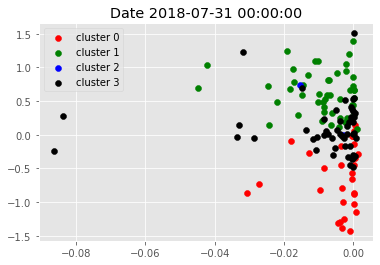

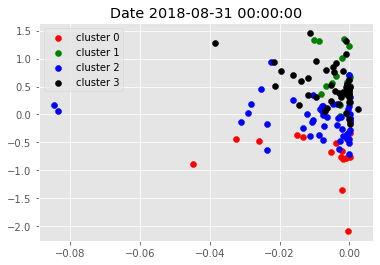

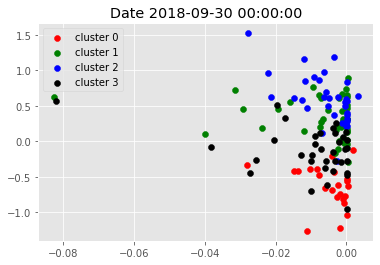

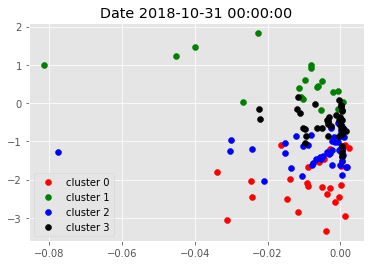

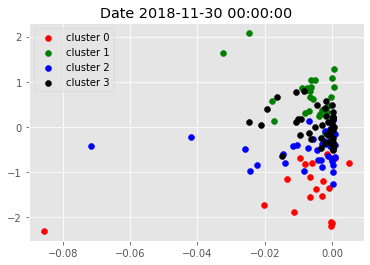

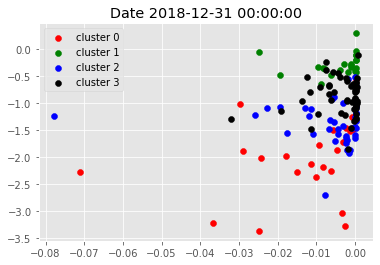

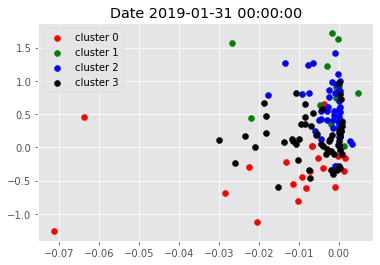

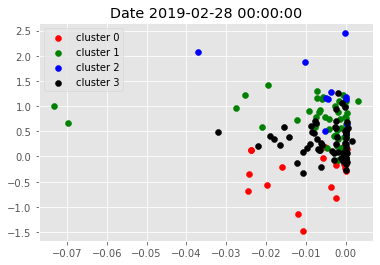

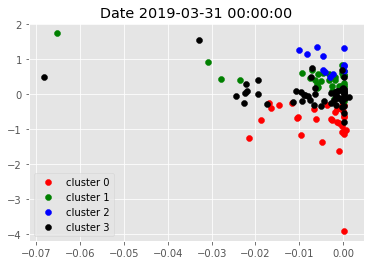

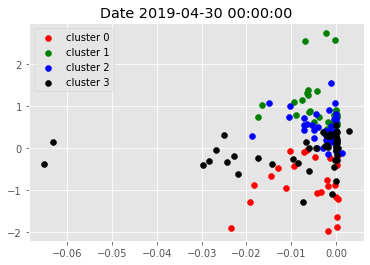

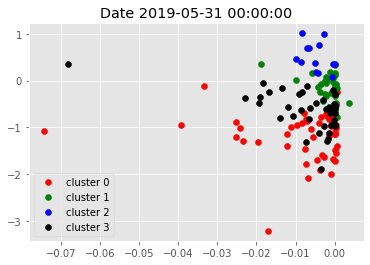

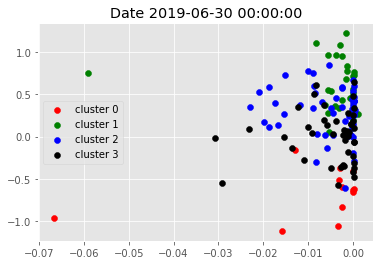

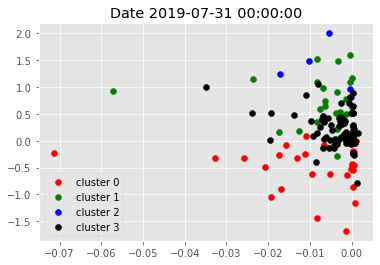

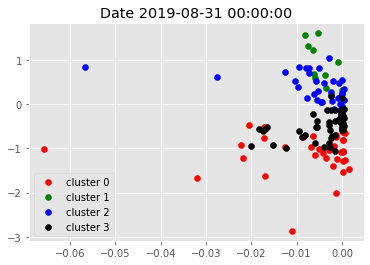

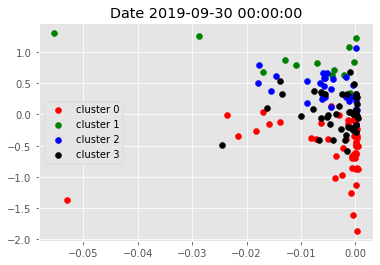

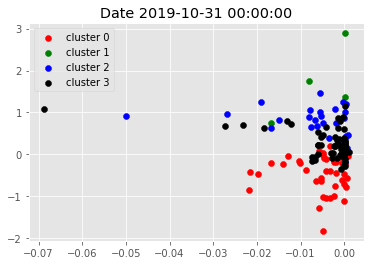

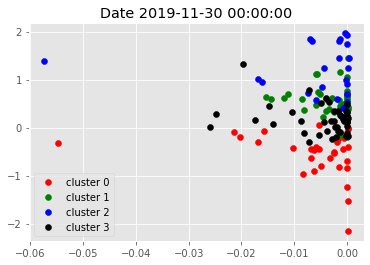

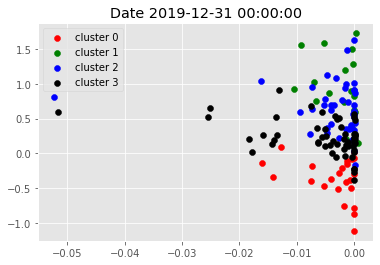

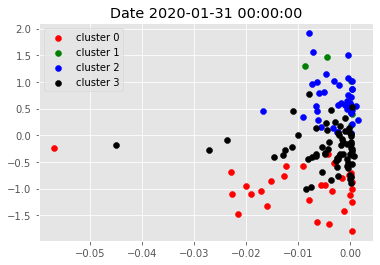

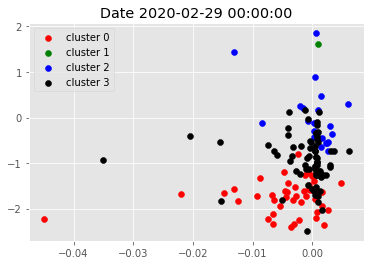

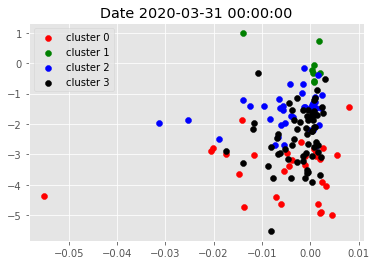

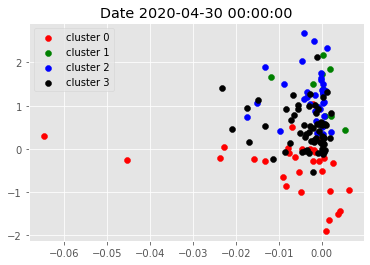

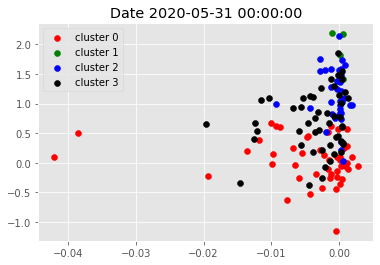

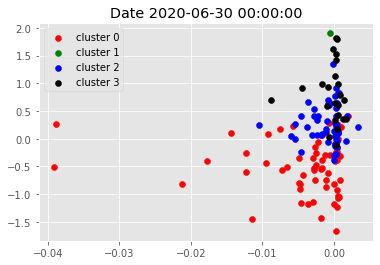

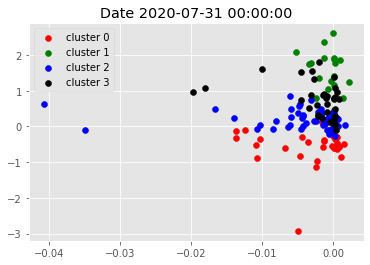

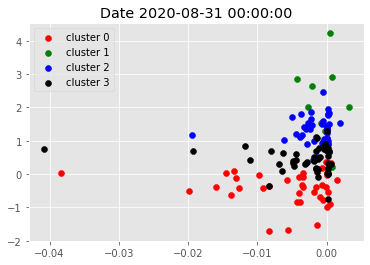

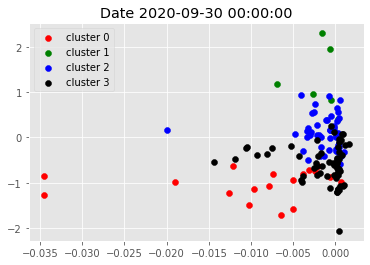

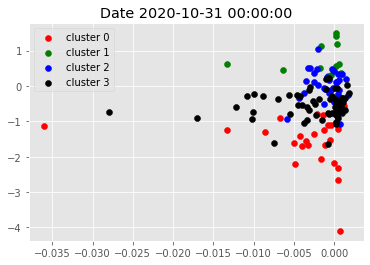

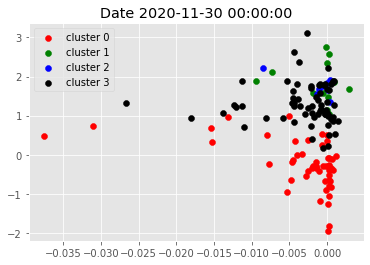

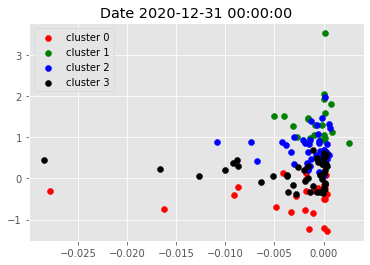

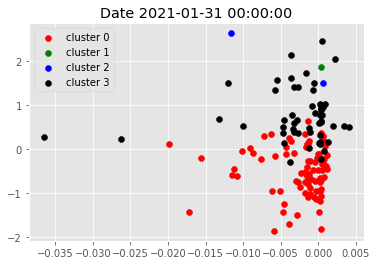

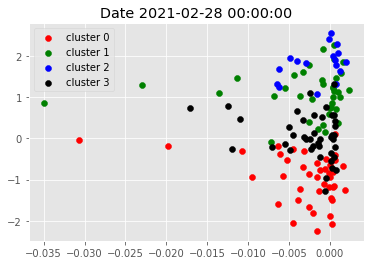

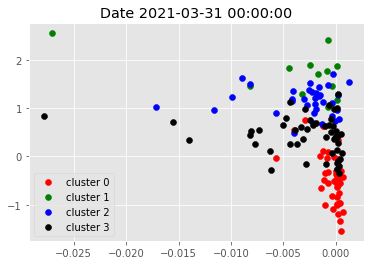

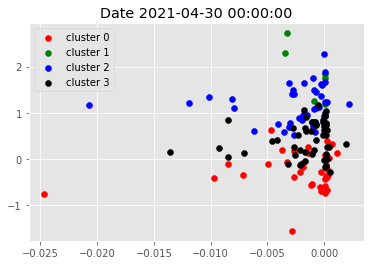

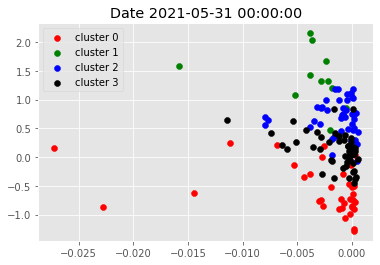

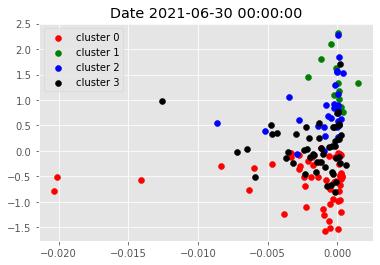

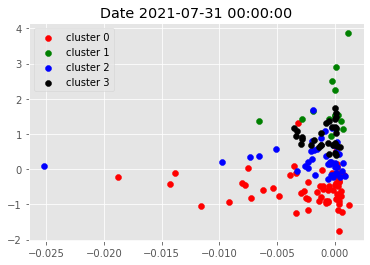

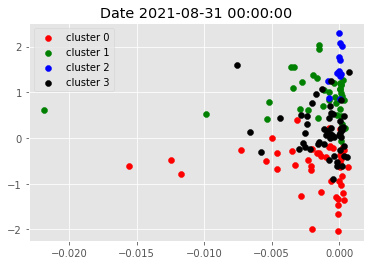

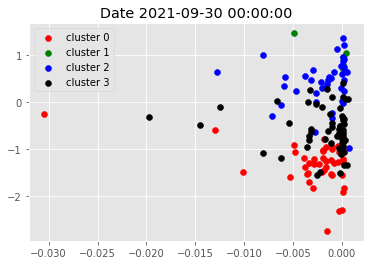

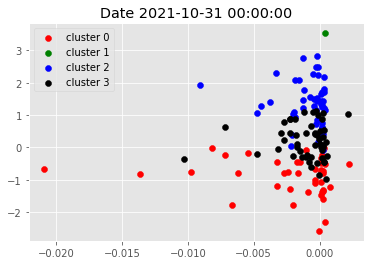

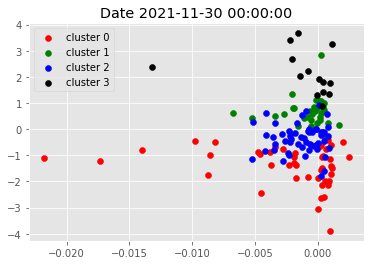

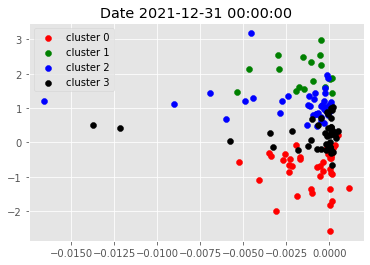

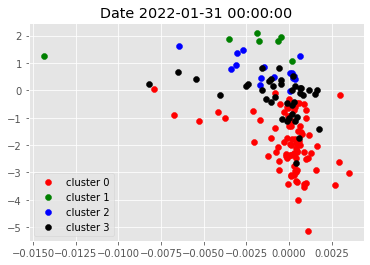

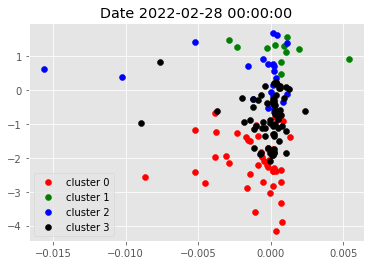

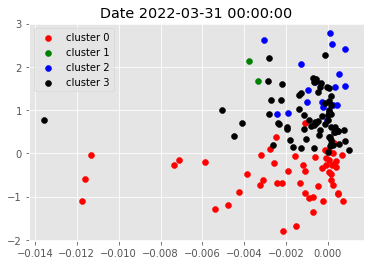

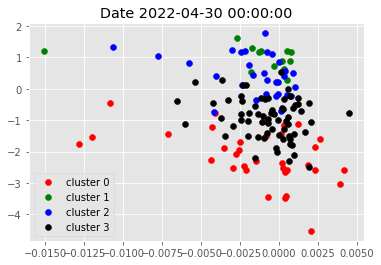

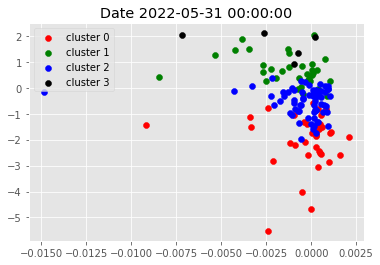

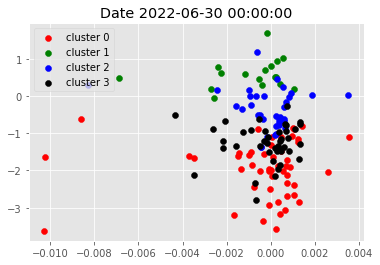

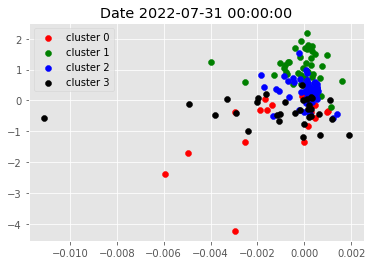

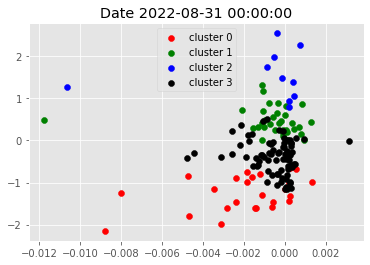

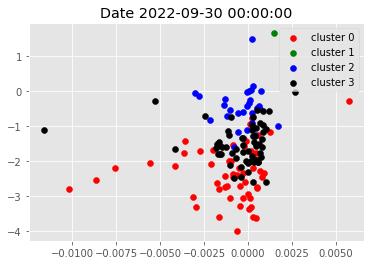

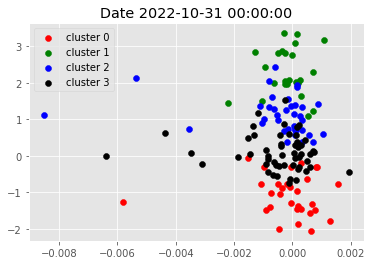

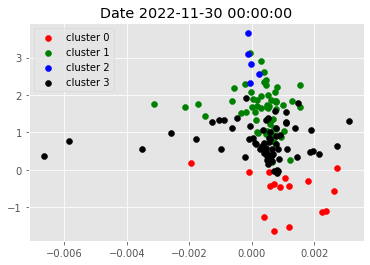

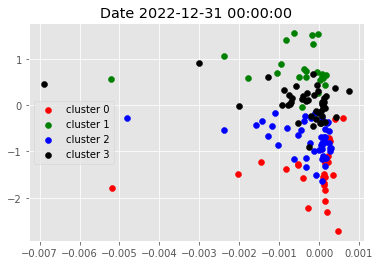

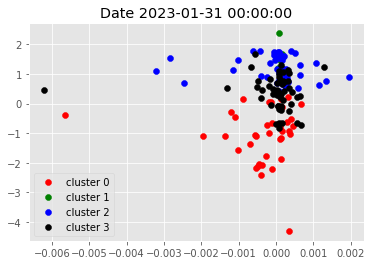

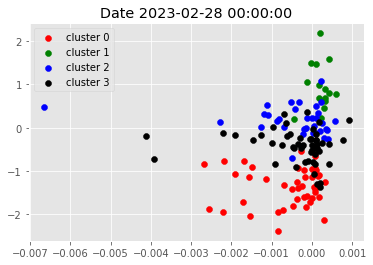

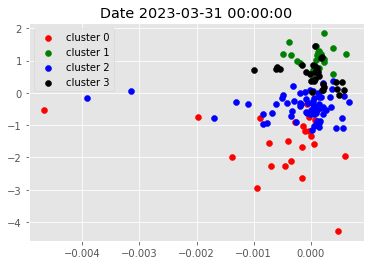

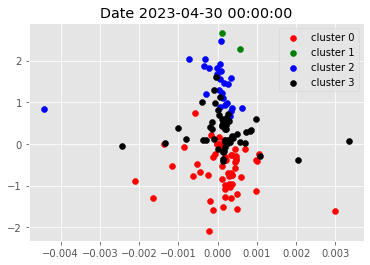

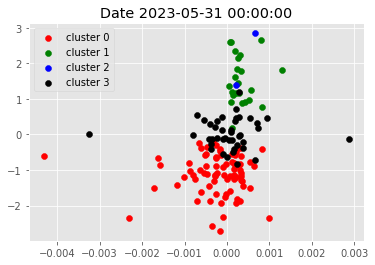

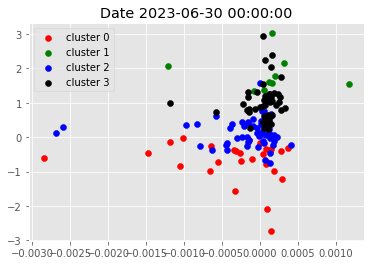

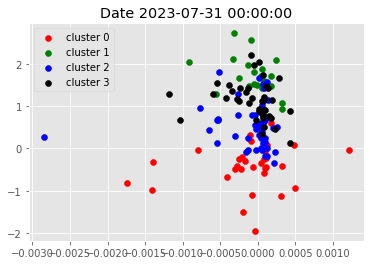

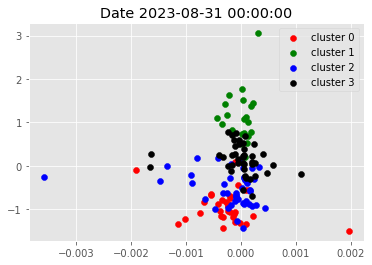

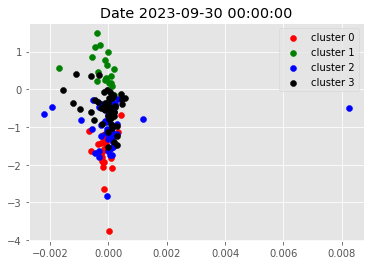

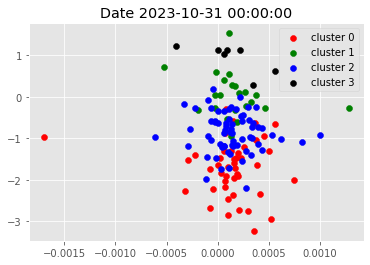

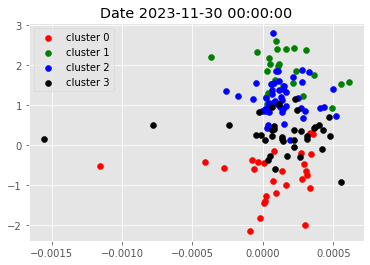

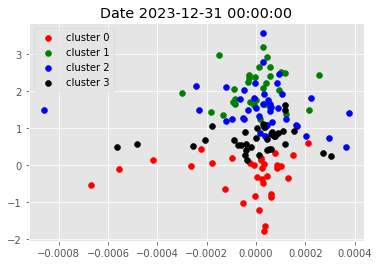

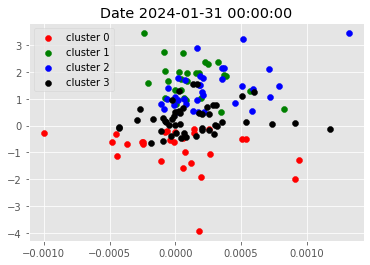

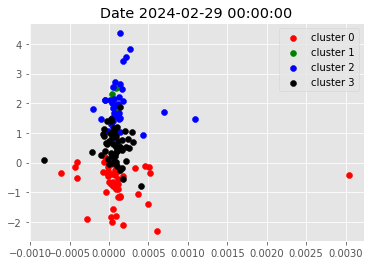

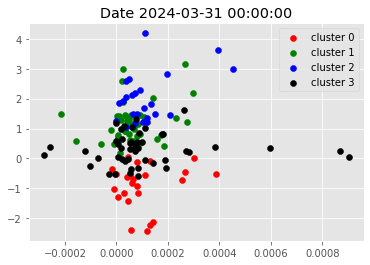

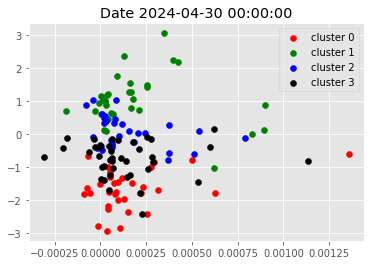

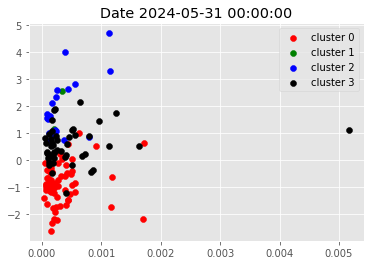

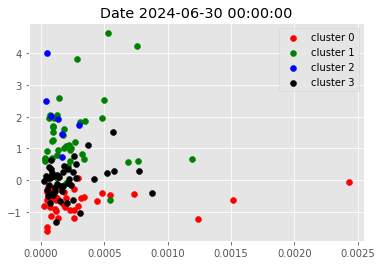

In [34]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    
    g = data.xs(i, level=0)
    
    plt.title(f'Date {i}')
    
    plot_clusters(g)

### Apply pre-defined centroids.

## 7. For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization

* First we will filter only stocks corresponding to the cluster we choose based on our hypothesis.

* Momentum is persistent and my idea would be that stocks clustered around RSI 70 centroid should continue to outperform in the following month - thus I would select stocks corresponding to cluster 3.


In [35]:
filtered_df = data[data['cluster']==3].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:
    
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()
    
fixed_dates

{'2018-08-01': ['AAL',
  'AAPL',
  'ADP',
  'AIG',
  'AMAT',
  'AMZN',
  'AXP',
  'AZO',
  'BA',
  'BIIB',
  'BRK-B',
  'CAT',
  'CHTR',
  'CTSH',
  'CVX',
  'DD',
  'DE',
  'DG',
  'DHR',
  'FCX',
  'FDX',
  'GE',
  'GOOGL',
  'GS',
  'HD',
  'HUM',
  'IBM',
  'ISRG',
  'LOW',
  'LRCX',
  'MGM',
  'MO',
  'MS',
  'MSFT',
  'NEE',
  'NKE',
  'ORCL',
  'OXY',
  'SBUX',
  'SLB',
  'T',
  'TMUS',
  'TXN',
  'UNH',
  'V',
  'VRTX',
  'WBA',
  'WFC',
  'WYNN',
  'XOM'],
 '2018-09-01': ['ABT',
  'ACN',
  'ADBE',
  'AMGN',
  'AXP',
  'AZO',
  'BIIB',
  'BMY',
  'BRK-B',
  'CMCSA',
  'COP',
  'CRM',
  'CSX',
  'CVS',
  'DAL',
  'DD',
  'DG',
  'DHR',
  'ELV',
  'HD',
  'HON',
  'HUM',
  'JNJ',
  'KR',
  'LUV',
  'MA',
  'MCD',
  'MMM',
  'MRK',
  'MSFT',
  'NKE',
  'NVDA',
  'PANW',
  'PFE',
  'PG',
  'PYPL',
  'SHW',
  'TMO',
  'TMUS',
  'ULTA',
  'UNH',
  'UNP',
  'UPS',
  'USB',
  'VRTX',
  'VZ',
  'WMT'],
 '2018-10-01': ['ABBV',
  'AIG',
  'AMT',
  'AXP',
  'BLK',
  'C',
  'CMCSA',
  'CTSH

### Define portfolio optimization function

* We will define a function which optimizes portfolio weights using PyPortfolioOpt package and EfficientFrontier optimizer to maximize the sharpe ratio.

* To optimize the weights of a given portfolio we would need to supply last 1 year prices to the function.

* Apply signle stock weight bounds constraint for diversification (minimum half of equaly weight and maximum 10% of portfolio).

In [36]:
!pip install PyPortfolioOpt

You should consider upgrading via the '/opt/anaconda3/bin/python -m pip install --upgrade pip' command.


In [37]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound=0):
    
    returns = expected_returns.mean_historical_return(prices=prices,
                                                      frequency=252)
    
    cov = risk_models.sample_cov(prices=prices,
                                 frequency=252)
    
    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, .1),
                           solver='SCS')
    
    weights = ef.max_sharpe()
    
    return ef.clean_weights()


* Download Fresh Daily Prices Data only for short listed stocks.

In [38]:
stocks = data.index.get_level_values('ticker').unique().tolist()

# new_df = yf.download(tickers=stocks,
#                      start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
#                      end=data.index.get_level_values('date').unique()[-1])

# new_df

[*********************100%%**********************]  155 of 155 completed


Price       Adj Close                                                  \
Ticker            AAL        AAPL        ABBV         ABT         ACN   
Date                                                                    
2017-07-31  48.955452   34.805634   51.445618   43.532551  115.462822   
2017-08-01  49.557201   35.114540   51.791481   43.505997  116.394966   
2017-08-02  48.965160   36.773731   52.034325   43.576828  115.283546   
2017-08-03  49.062210   36.406322   52.240372   43.514851  116.538391   
2017-08-04  49.304852   36.598213   52.240372   43.603374  116.699730   
...               ...         ...         ...         ...         ...   
2024-06-24  11.160000  208.139999  171.167618  104.744308  305.868591   
2024-06-25  11.130000  209.070007  169.195724  104.933296  305.828796   
2024-06-26  11.120000  213.250000  169.592072  104.326515  303.289917   
2024-06-27  11.280000  214.100006  167.451752  104.097733  301.866150   
2024-06-28  11.330000  210.619995  169.958725  103.361641  302.085205   

Price                                                                  ...  \
Ticker            ADBE         ADI         ADP        ADSK        AIG  ...   
Date                                                                   ...   
2017-07-31  146.490005   69.072273  102.579742  110.790001  54.342331  ...   
2017-08-01  147.360001   69.019783  100.742241  111.379997  54.367256  ...   
2017-08-02  147.130005   68.906151   99.422356  109.129997  54.715973  ...   
2017-08-03  147.789993   68.136826   96.420288  107.879997  54.848808  ...   
2017-08-04  147.710007   67.996941   96.092461  108.389999  54.035141  ...   
...                ...         ...         ...         ...        ...  ...   
2024-06-24  524.169983  228.460007  249.199997  239.169998  76.010002  ...   
2024-06-25  526.880005  230.339996  248.399994  242.529999  74.510002  ...   
2024-06-26  528.659973  227.839996  238.020004  243.279999  74.489998  ...   
2024-06-27  546.760010  226.679993  237.300003  243.679993  74.970001  ...   
2024-06-28  555.539978  228.259995  238.690002  247.449997  74.239998  ...   

Price         Volume                                                   \
Ticker             V      VLO     VRTX        VZ        WBA       WDC   
Date                                                                    
2017-07-31   7576600  7354800  2972700  28456800    4853500   5093600   
2017-08-01   6018100  5330100  1621100  33498200    4892600   4010000   
2017-08-02   5955600  3724900  1781700  19233400    4216400   3757500   
2017-08-03   5697500  3342700  1407100  15190100    4666500   3511100   
2017-08-04   4618000  3201800   807800  13841700    3777300  10704300   
...              ...      ...      ...       ...        ...       ...   
2024-06-24  24149600  2851300  1188600  20773800   13632500   5122600   
2024-06-25  19897700  4862900  1195800  18933000   10336600   3764400   
2024-06-26  12172000  3843100  1272300  19709900   12933400   3663400   
2024-06-27  10529100  2540100   959600  15560800  132813000   4344900   
2024-06-28  13957300  3898900  3234600  27639200   54346500   8582800   

Price                                              
Ticker           WFC       WMT     WYNN       XOM  
Date                                               
2017-07-31  20378100  18789600  2475300  12820200  
2017-08-01  19350300  17179500  2424100  10421200  
2017-08-02  19422100  26019000  2906300  10410100  
2017-08-03  19374700  29840700  1238600  10136700  
2017-08-04  44664600  21425400  1034400   8292200  
...              ...       ...      ...       ...  
2024-06-24  16198300  12470400  1828400  16266700  
2024-06-25  27490700  20904000  1489200  16213700  
2024-06-26  30425700  14177500  1089700  15771800  
2024-06-27  13832200  12899200  1266600  16812700  
2024-06-28  31074500  18816700  2199400  24565900  

[1740 rows x 930 columns]

In [49]:
start_date = df_final.index.get_level_values('date').unique()[0] - pd.DateOffset(months=12)
end_date = df_final.index.get_level_values('date').unique()[-1]

df_final = df_final.rename(index={0: "Date", 1: "Ticker"}, columns ={'adj close': 'Adj Close', 'volume': 'Volume'})

# Slice the dataframe using pd.IndexSlice
new_df = df_final.loc[pd.IndexSlice[start_date:end_date, stocks], :]
new_df = new_df.unstack()
new_df

Adj Close                                                  \
ticker            AAL        AAPL        ABBV         ABT         ACN   
date                                                                    
2016-07-05  27.802406   21.811760   43.482296   33.861183   99.298927   
2016-07-06  27.245012   21.935753   44.500526   35.054573   99.667679   
2016-07-07  28.254086   22.029894   44.542671   35.509598   98.947769   
2016-07-08  28.869141   22.199821   45.055302   35.964626  101.063667   
2016-07-11  29.945488   22.268711   45.188728   36.162102  101.370964   
...               ...         ...         ...         ...         ...   
2024-06-24  11.160000  208.139999  171.167618  104.744308  305.868591   
2024-06-25  11.130000  209.070007  169.195724  104.933296  305.828796   
2024-06-26  11.120000  213.250000  169.592072  104.326515  303.289917   
2024-06-27  11.280000  214.100006  167.451752  104.097733  301.866150   
2024-06-28  11.330000  210.619995  169.958725  103.361641  302.085205   

                                                                       ...  \
ticker            ADBE         ADI         ADP        ADSK        AIG  ...   
date                                                                   ...   
2016-07-05   94.730003   47.280479   78.665138   52.799999  41.655487  ...   
2016-07-06   95.180000   47.365891   78.757866   52.959999  41.696156  ...   
2016-07-07   95.139999   47.784378   78.825294   53.529999  42.151661  ...   
2016-07-08   96.790001   49.313145   79.643082   55.139999  43.119656  ...   
2016-07-11   97.139999   49.748714   80.207924   55.490002  43.347404  ...   
...                ...         ...         ...         ...        ...  ...   
2024-06-24  524.169983  228.460007  249.199997  239.169998  76.010002  ...   
2024-06-25  526.880005  230.339996  248.399994  242.529999  74.510002  ...   
2024-06-26  528.659973  227.839996  238.020004  243.279999  74.489998  ...   
2024-06-27  546.760010  226.679993  237.300003  243.679993  74.970001  ...   
2024-06-28  555.539978  228.259995  238.690002  247.449997  74.239998  ...   

                Volume                                                  \
ticker              VZ          WBA        WDC         WFC         WMT   
date                                                                     
2016-07-05  20703200.0    7629300.0  5728200.0  22213000.0  32245800.0   
2016-07-06  15761500.0   10537400.0  4268600.0  19024100.0  33188100.0   
2016-07-07  13574100.0    5560000.0  7831800.0  17946200.0  23378400.0   
2016-07-08  15946200.0    5973500.0  7267200.0  19775700.0  27382800.0   
2016-07-11  12434700.0    3607700.0  5546200.0  16008700.0  27120300.0   
...                ...          ...        ...         ...         ...   
2024-06-24  20773800.0   13632500.0  5122600.0  16198300.0  12470400.0   
2024-06-25  18933000.0   10336600.0  3764400.0  27490700.0  20904000.0   
2024-06-26  19709900.0   12933400.0  3663400.0  30425700.0  14177500.0   
2024-06-27  15560800.0  132813000.0  4344900.0  13832200.0  12899200.0   
2024-06-28  27639200.0   54346500.0  8582800.0  31074500.0  18816700.0   

                                                                     
ticker           WYNN         XOM       MRNA        UBER       CRWD  
date                                                                 
2016-07-05  2405100.0  10744100.0        NaN         NaN        NaN  
2016-07-06  2133700.0  13144400.0        NaN         NaN        NaN  
2016-07-07  1999500.0  12240700.0        NaN         NaN        NaN  
2016-07-08  2006400.0   9807600.0        NaN         NaN        NaN  
2016-07-11  4057100.0   8335700.0        NaN         NaN        NaN  
...               ...         ...        ...         ...        ...  
2024-06-24  1828400.0  16266700.0  3443000.0  12479300.0  5400900.0  
2024-06-25  1489200.0  16213700.0  3387300.0  18911600.0  3203100.0  
2024-06-26  1089700.0  15771800.0  7721600.0  10232600.0  2952100.0  
2024-06-27  1266600

* Calculate daily returns for each stock which could land up in our portfolio.

* Then loop over each month start, select the stocks for the month and calculate their weights for the next month.

* If the maximum sharpe ratio optimization fails for a given month, apply equally-weighted weights.

* Calculated each day portfolio return.

In [52]:
returns_dataframe = np.log(new_df['Adj Close']).diff()
returns_dataframe

ticker,AAL,AAPL,ABBV,ABT,ACN,ADBE,ADI,ADP,ADSK,AIG,...,VZ,WBA,WDC,WFC,WMT,WYNN,XOM,MRNA,UBER,CRWD
date,,,,,,,,,,,,,,,,,,,,,
2016-07-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-07-06,-0.020252,0.005669,0.023147,0.034637,0.003707,0.004739,0.001805,0.001178,0.003026,0.000976,...,0.005258,-0.023870,0.016412,0.009477,0.009254,0.009272,0.011437,NaN,NaN,NaN
2016-07-07,0.036368,0.004282,0.000947,0.012897,-0.007249,-0.000420,0.008796,0.000856,0.010705,0.010865,...,-0.015765,-0.012959,0.047260,0.003210,-0.003936,-0.010845,-0.012083,NaN,NaN,NaN
2016-07-08,0.021535,0.007684,0.011443,0.012733,0.021159,0.017194,0.031492,0.010321,0.029633,0.022705,...,0.009346,0.016020,0.034845,0.020933,0.004207,0.008841,0.006220,NaN,NaN,NaN
2016-07-11,0.036605,0.003098,0.002957,0.005476,0.003036,0.003610,0.008794,0.007067,0.006327,0.005268,...,0.000537,0.002564,0.002631,0.006050,0.002975,0.047330,0.003735,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-24,-0.003578,0.003128,0.013698,-0.003981,-0.005745,-0.017531,-0.011273,0.004948,-0.013043,0.014845,...,0.022848,-0.003764,-0.004895,0.015541,0.014473,-0.008716,0.029271,0.026629,0.004689,-0.007119
2024-06-25,-0.002692,0.004458,-0.011587,0.001803,-0.000130,0.005157,0.008195,-0.003215,0.013951,-0.019932,...,-0.002188,-0.013287,0.019178,-0.031153,-0.021715,-0.009019,0.002802,0.004370,0.011838,0.023095
2024-06-26,-0.000899,0.019796,0.002340,-0.005799,-0.008336,0.003373,-0.010913,-0.042686,0.003088,-0.000269,...,-0.001462,-0.002551,-0.018250,-0.003327,0.012822,-0.001927,0.000350,-0.116648,-0.007453,-0.016660


In [53]:
fixed_dates.keys()

dict_keys(['2018-08-01', '2018-09-01', '2018-10-01', '2018-11-01', '2018-12-01', '2019-01-01', '2019-02-01', '2019-03-01', '2019-04-01', '2019-05-01', '2019-06-01', '2019-07-01', '2019-08-01', '2019-09-01', '2019-10-01', '2019-11-01', '2019-12-01', '2020-01-01', '2020-02-01', '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01', '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01', '2020-11-01', '2020-12-01', '2021-01-01', '2021-02-01', '2021-03-01', '2021-04-01', '2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01', '2021-09-01', '2021-10-01', '2021-11-01', '2021-12-01', '2022-01-01', '2022-02-01', '2022-03-01', '2022-04-01', '2022-05-01', '2022-06-01', '2022-07-01', '2022-08-01', '2022-09-01', '2022-10-01', '2022-11-01', '2022-12-01', '2023-01-01', '2023-02-01', '2023-03-01', '2023-04-01', '2023-05-01', '2023-06-01', '2023-07-01', '2023-08-01', '2023-09-01', '2023-10-01', '2023-11-01', '2023-12-01', '2024-01-01', '2024-02-01', '2024-03-01', '2024-04-01', '2024-05-01', '2024-06-

In [57]:
for start_date in fixed_dates.keys():
    end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')
    cols = fixed_dates[start_date]
    optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')
    optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')
#     optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]
     
    print(start_date)
    print(end_date)
    print(cols)
    print(optimization_start_date)
    print(optimization_end_date)

2018-08-01
2018-08-31
['AAL', 'AAPL', 'ADP', 'AIG', 'AMAT', 'AMZN', 'AXP', 'AZO', 'BA', 'BIIB', 'BRK-B', 'CAT', 'CHTR', 'CTSH', 'CVX', 'DD', 'DE', 'DG', 'DHR', 'FCX', 'FDX', 'GE', 'GOOGL', 'GS', 'HD', 'HUM', 'IBM', 'ISRG', 'LOW', 'LRCX', 'MGM', 'MO', 'MS', 'MSFT', 'NEE', 'NKE', 'ORCL', 'OXY', 'SBUX', 'SLB', 'T', 'TMUS', 'TXN', 'UNH', 'V', 'VRTX', 'WBA', 'WFC', 'WYNN', 'XOM']
2017-08-01
2018-07-31
2018-09-01
2018-09-30
['ABT', 'ACN', 'ADBE', 'AMGN', 'AXP', 'AZO', 'BIIB', 'BMY', 'BRK-B', 'CMCSA', 'COP', 'CRM', 'CSX', 'CVS', 'DAL', 'DD', 'DG', 'DHR', 'ELV', 'HD', 'HON', 'HUM', 'JNJ', 'KR', 'LUV', 'MA', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'NVDA', 'PANW', 'PFE', 'PG', 'PYPL', 'SHW', 'TMO', 'TMUS', 'ULTA', 'UNH', 'UNP', 'UPS', 'USB', 'VRTX', 'VZ', 'WMT']
2017-09-01
2018-08-31
2018-10-01
2018-10-31
['ABBV', 'AIG', 'AMT', 'AXP', 'BLK', 'C', 'CMCSA', 'CTSH', 'EA', 'EXPE', 'FCX', 'FDX', 'GOOG', 'GOOGL', 'HAL', 'INTC', 'JPM', 'KR', 'MCK', 'MDLZ', 'MGM', 'MMM', 'MO', 'NEE', 'PANW', 'PEP', 'PG', 'P

In [65]:


portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    
    try:

        end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')

        cols = fixed_dates[start_date]

        optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')

        optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')
        
        optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]
        
        success = False
        try:
            weights = optimize_weights(prices=optimization_df,
                                   lower_bound=round(1/(len(optimization_df.columns)*2),4))

            weights = pd.DataFrame(weights, index=pd.Series(0))
            
            success = True
        except:
            print(f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights')
        
        if success==False:
            weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                     index=optimization_df.columns.tolist(),
                                     columns=pd.Series(0)).T
        
        temp_df = returns_dataframe[start_date:end_date]

        temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
                   .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                          left_index=True,
                          right_index=True)\
                   .reset_index().set_index(['date', 'ticker']).unstack().stack()

        temp_df.index.names = ['date', 'ticker']

        temp_df['weighted_return'] = temp_df['return']*temp_df['weight']

        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')

        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)
    
    except Exception as e:
        print(e)

portfolio_df = portfolio_df.drop_duplicates()

portfolio_df

Max Sharpe Optimization failed for 2019-01-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2020-04-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2021-07-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-06-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2023-03-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2023-11-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2024-03-01, Continuing with Equal-Weights
'return'


,Strategy Return
date,
2018-08-01,-0.013621
2018-08-02,0.000766
2018-08-03,0.004983
2018-08-06,0.003268
2018-08-07,0.002209
...,...
2024-06-24,0.009733
2024-06-25,-0.000900
2024-06-26,-0.001863


## 8. Visualize Portfolio returns and compare to SP500 returns.

In [41]:
spy = yf.download(tickers='SPY',
                  start='2015-01-01',
                  end=dt.date.today())

spy_ret = np.log(spy[['Adj Close']]).diff().dropna().rename({'Adj Close':'SPY Buy&Hold'}, axis=1)

portfolio_df = portfolio_df.merge(spy_ret,
                                  left_index=True,
                                  right_index=True)

portfolio_df

[*********************100%%**********************]  1 of 1 completed


,SPY Buy&Hold


In [71]:
portfolio_df = portfolio_df.merge(spy_ret,
                                  left_index=True,
                                  right_index=True)

portfolio_df

,Strategy Return,SPY Buy&Hold
2018-08-01,-0.013621,-0.001672
2018-08-02,0.000766,0.005433
2018-08-03,0.004983,0.004276
2018-08-06,0.003268,0.003661
2018-08-07,0.002209,0.003296
...,...,...
2024-06-24,0.009733,-0.003256
2024-06-25,-0.000900,0.003843
2024-06-26,-0.001863,0.001247
2024-06-27,-0.006486,0.001575


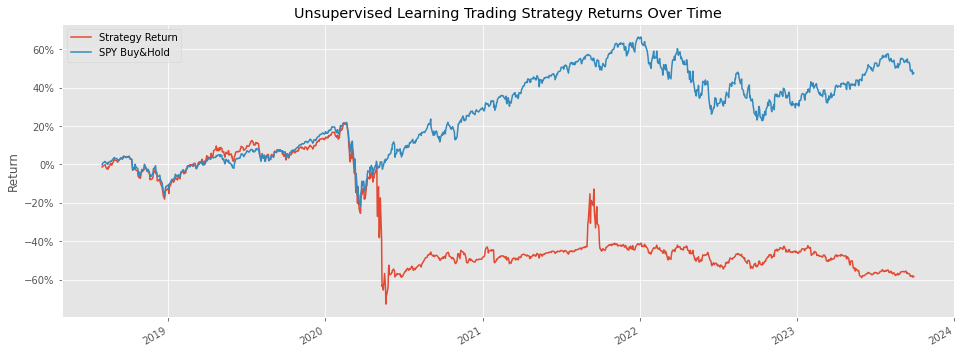

In [72]:
import matplotlib.ticker as mtick

plt.style.use('ggplot')

portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1

portfolio_cumulative_return[:'2023-09-29'].plot(figsize=(16,6))

plt.title('Unsupervised Learning Trading Strategy Returns Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()


# Twitter Sentiment Investing Strategy

## 1. Load Twitter Sentiment Data

* Load the twitter sentiment dataset, set the index, calculat engagement ratio and filter out stocks with no significant twitter activity.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf
import os
plt.style.use('ggplot')

data_folder = 'C:/Users/user/Desktop/Python Scripts'

sentiment_df = pd.read_csv(os.path.join(data_folder, 'sentiment_data.csv'))

sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])

sentiment_df = sentiment_df.set_index(['date', 'symbol'])

sentiment_df['engagement_ratio'] = sentiment_df['twitterComments']/sentiment_df['twitterLikes']

sentiment_df = sentiment_df[(sentiment_df['twitterLikes']>20)&(sentiment_df['twitterComments']>10)]

sentiment_df

## 2. Aggregate Monthly and calculate average sentiment for the month

* Aggregate on a monthly level and calculate average monthly metric, for the one we choose.

In [ ]:
aggragated_df = (sentiment_df.reset_index('symbol').groupby([pd.Grouper(freq='M'), 'symbol'])
                    [['engagement_ratio']].mean())

aggragated_df['rank'] = (aggragated_df.groupby(level=0)['engagement_ratio']
                         .transform(lambda x: x.rank(ascending=False)))

aggragated_df

## 3. Select Top 5 Stocks based on their cross-sectional ranking for each month

* Select top 5 stocks by rank for each month and fix the date to start at beginning of next month.

In [ ]:
filtered_df = aggragated_df[aggragated_df['rank']<6].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'symbol'])

filtered_df.head(20)

## 4. Extract the stocks to form portfolios with at the start of each new month

* Create a dictionary containing start of month and corresponded selected stocks.

In [ ]:
dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:
    
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()
    
fixed_dates

## 5. Download fresh stock prices for only selected/shortlisted stocks

In [ ]:
stocks_list = sentiment_df.index.get_level_values('symbol').unique().tolist()

prices_df = yf.download(tickers=stocks_list,
                        start='2021-01-01',
                        end='2023-03-01')

## 6. Calculate Portfolio Returns with monthly rebalancing


In [ ]:
returns_df = np.log(prices_df['Adj Close']).diff().dropna()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    
    end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd()).strftime('%Y-%m-%d')
    
    cols = fixed_dates[start_date]
    
    temp_df = returns_df[start_date:end_date][cols].mean(axis=1).to_frame('portfolio_return')
    
    portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)
    
portfolio_df

## 7. Download NASDAQ/QQQ prices and calculate returns to compare to our strategy

In [ ]:
qqq_df = yf.download(tickers='QQQ',
                     start='2021-01-01',
                     end='2023-03-01')

qqq_ret = np.log(qqq_df['Adj Close']).diff().to_frame('nasdaq_return')

portfolio_df = portfolio_df.merge(qqq_ret,
                                  left_index=True,
                                  right_index=True)

portfolio_df

In [ ]:
portfolios_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum()).sub(1)

portfolios_cumulative_return.plot(figsize=(16,6))

plt.title('Twitter Engagement Ratio Strategy Return Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()

# Intraday Strategy Using GARCH Model


* Using simulated daily data and intraday 5-min data.
* Load Daily and 5-minute data.
* Define function to fit GARCH model on the daily data and predict 1-day ahead volatility in a rolling window.
* Calculate prediction premium and form a daily signal from it.
* Merge with intraday data and calculate intraday indicators to form the intraday signal.
* Generate the position entry and hold until the end of the day.
* Calculate final strategy returns.

## 1. Load Simulated Daily and Simulated 5-minute data.

* We are loading both datasets, set the indexes and calculate daily log returns.

In [ ]:
import matplotlib.pyplot as plt
from arch import arch_model
import pandas_ta
import pandas as pd
import numpy as np
import os

data_folder = 'C:/Users/user/Desktop/Python Scripts'

daily_df = pd.read_csv(os.path.join(data_folder, 'simulated_daily_data.csv'))

daily_df = daily_df.drop('Unnamed: 7', axis=1)

daily_df['Date'] = pd.to_datetime(daily_df['Date'])

daily_df = daily_df.set_index('Date')


intraday_5min_df = pd.read_csv(os.path.join(data_folder, 'simulated_5min_data.csv'))

intraday_5min_df = intraday_5min_df.drop('Unnamed: 6', axis=1)

intraday_5min_df['datetime'] = pd.to_datetime(intraday_5min_df['datetime'])

intraday_5min_df = intraday_5min_df.set_index('datetime')

intraday_5min_df['date'] = pd.to_datetime(intraday_5min_df.index.date)

intraday_5min_df

## 2. Define function to fit GARCH model and predict 1-day ahead volatility in a rolling window.

* We are first calculating the 6-month rolling variance and then we are creating a function in a 6-month rolling window to fit a garch model and predict the next day variance.

In [ ]:
daily_df['log_ret'] = np.log(daily_df['Adj Close']).diff()

daily_df['variance'] = daily_df['log_ret'].rolling(180).var()

daily_df = daily_df['2020':]

def predict_volatility(x):
    
    best_model = arch_model(y=x,
                            p=1,
                            q=3).fit(update_freq=5,
                                     disp='off')
    
    variance_forecast = best_model.forecast(horizon=1).variance.iloc[-1,0]

    print(x.index[-1])
    
    return variance_forecast

daily_df['predictions'] = daily_df['log_ret'].rolling(180).apply(lambda x: predict_volatility(x))

daily_df = daily_df.dropna()

daily_df

## 3. Calculate prediction premium and form a daily signal from it.

* We are calculating the prediction premium. And calculate its 6-month rolling standard deviation.

* From this we are creating our daily signal.

In [ ]:
daily_df['prediction_premium'] = (daily_df['predictions']-daily_df['variance'])/daily_df['variance']

daily_df['premium_std'] = daily_df['prediction_premium'].rolling(180).std()

daily_df['signal_daily'] = daily_df.apply(lambda x: 1 if (x['prediction_premium']>x['premium_std'])
                                         else (-1 if (x['prediction_premium']<x['premium_std']*-1) else np.nan),
                                         axis=1)

daily_df['signal_daily'] = daily_df['signal_daily'].shift()

daily_df

In [ ]:
plt.style.use('ggplot')

daily_df['signal_daily'].plot(kind='hist')

plt.show()

## 4. Merge with intraday data and calculate intraday indicators to form the intraday signal.

* Calculate all intraday indicators and intraday signal.

In [ ]:
final_df = intraday_5min_df.reset_index()\
                            .merge(daily_df[['signal_daily']].reset_index(),
                                   left_on='date',
                                   right_on='Date')\
                            .drop(['date','Date'], axis=1)\
                            .set_index('datetime')

final_df['rsi'] = pandas_ta.rsi(close=final_df['close'],
                                length=20)

final_df['lband'] = pandas_ta.bbands(close=final_df['close'],
                                     length=20).iloc[:,0]

final_df['uband'] = pandas_ta.bbands(close=final_df['close'],
                                     length=20).iloc[:,2]

final_df['signal_intraday'] = final_df.apply(lambda x: 1 if (x['rsi']>70)&
                                                            (x['close']>x['uband'])
                                             else (-1 if (x['rsi']<30)&
                                                         (x['close']<x['lband']) else np.nan),
                                             axis=1)

final_df['return'] = np.log(final_df['close']).diff()

final_df

## 5. Generate the position entry and hold until the end of the day.

In [ ]:
final_df['return_sign'] = final_df.apply(lambda x: -1 if (x['signal_daily']==1)&(x['signal_intraday']==1)
                                        else (1 if (x['signal_daily']==-1)&(x['signal_intraday']==-1) else np.nan),
                                        axis=1)

final_df['return_sign'] = final_df.groupby(pd.Grouper(freq='D'))['return_sign']\
                                  .transform(lambda x: x.ffill())

final_df['forward_return'] = final_df['return'].shift(-1)

final_df['strategy_return'] = final_df['forward_return']*final_df['return_sign']

daily_return_df = final_df.groupby(pd.Grouper(freq='D'))['strategy_return'].sum()

## 6. Calculate final strategy returns.

In [ ]:
import matplotlib.ticker as mtick

strategy_cumulative_return = np.exp(np.log1p(daily_return_df).cumsum()).sub(1)

strategy_cumulative_return.plot(figsize=(16,6))

plt.title('Intraday Strategy Returns')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()
                                                                            